## Implementing strategy from "High-frequency trading in a limit order book" by Sasha Stoikov

https://www.math.nyu.edu/~avellane/HighFrequencyTrading.pdf

* Find volatility from market data
* Grid searching over 320 params combinations - $\kappa, \gamma, \theta$ and position hold time
* Plotting results

In [87]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

from simulator import Sim
from strategies import StoikovStrategyOriginal
from get_info import get_pnl
from load_data import load_md_from_file

from sklearn.model_selection import ParameterGrid

PATH_TO_FILE = 'md/btcusdt:Binance:LinearPerpetual/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
T = pd.Timedelta(1, 'h').delta
md = load_md_from_file(path=PATH_TO_FILE, T=T)

### 1. Calculating volatility

In [3]:
mdata = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv')
#mdata['receive_ts'] = pd.to_datetime(mdata['receive_ts'])

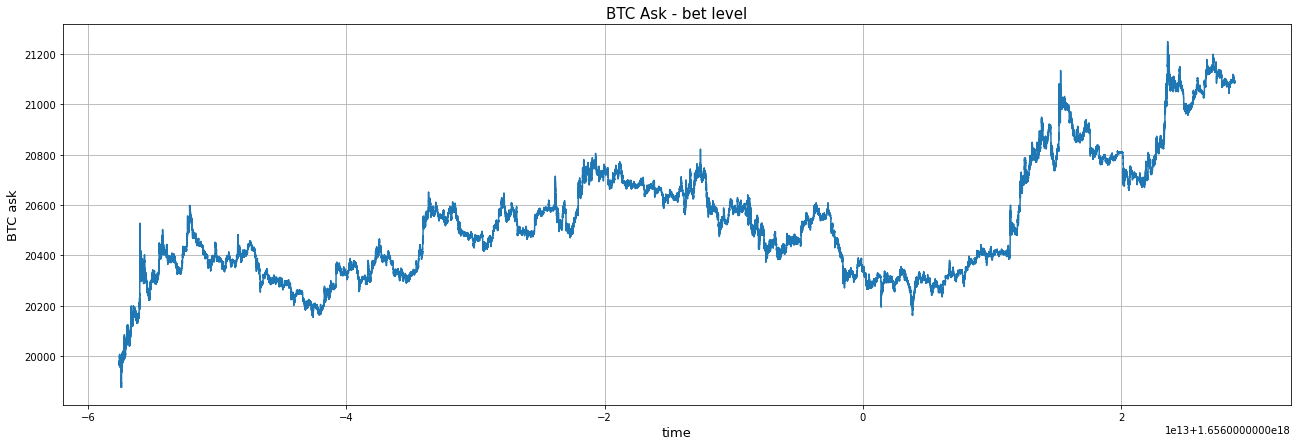

In [4]:
plt.figure(figsize=(22, 7))

plt.plot(mdata['receive_ts'], (mdata['btcusdt:Binance:LinearPerpetual_ask_price_0'] + mdata['btcusdt:Binance:LinearPerpetual_bid_price_0'])/2, '-')
plt.xlabel("time", fontsize=13)
plt.ylabel("BTC ask", fontsize=13)
plt.title("BTC Ask - bet level", fontsize=15)
plt.grid()

In [5]:
mdata = pd.read_csv('md/btcusdt:Binance:LinearPerpetual/lobs.csv')
mdata['receive_ts'] = pd.to_datetime(mdata['receive_ts'])
mdata['btcusdt:Binance:LinearPerpetual_ask_price_0'].describe()

count    2.541356e+06
mean     2.053025e+04
std      2.323556e+02
min      1.987500e+04
25%      2.034250e+04
50%      2.048960e+04
75%      2.068010e+04
max      2.125000e+04
Name: btcusdt:Binance:LinearPerpetual_ask_price_0, dtype: float64

Calculate volatility on half hour data

In [16]:
half_hour_data = mdata.iloc[::5000].reset_index()

In [17]:
half_hour_data['log_returns'] = np.log(half_hour_data['btcusdt:Binance:LinearPerpetual_ask_price_0'].shift(1).fillna(method='bfill')/half_hour_data['btcusdt:Binance:LinearPerpetual_ask_price_0'])


#### Log returns plot

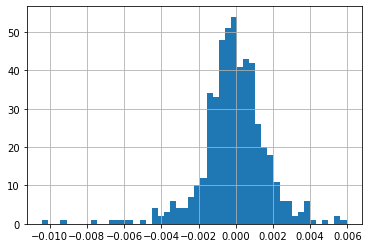

In [18]:
half_hour_data['log_returns'].hist(bins=50, label='Log returns')
plt.show()

In [19]:
avg_log_ret = half_hour_data['log_returns'].mean()
ubiased_variance = (1/(len(half_hour_data['log_returns'])-1) * sum((half_hour_data['log_returns']-avg_log_ret)**2))**.5

In [22]:
delta = half_hour_data['receive_ts'].iloc[-1] - half_hour_data['receive_ts'].iloc[0]
seconds = delta.total_seconds()

In [23]:
time_window =  (seconds / 3.154e+7)

In [24]:
ubiased_variance / time_window**.5

0.03366682888107033

**Daily volatility - 3.36%**

https://buybitcoinworldwide.com/ethereum-volatility/

### 2. Classic Stoikov - params grid search

#### Grid search by gamma, sigma, kappa, hold time on 1 hour data


* We will track most popular metrics

In [33]:
grid_delay = [pd.Timedelta(0.05, 's').delta, pd.Timedelta(0.1, 's').delta, pd.Timedelta(0.5, 's').delta, pd.Timedelta(1, 's').delta]
grid_sigma = [0.1, 1, 10, 50]
grid_gamma = [0.01, 0.1, 1, 4, 10]
grid_kappa = [0.1, 1, 1.5, 3]

param_grid = {'delay': grid_delay, 'sigma': grid_sigma, 'gamma' : grid_gamma, 'kappa': grid_kappa}

grid = ParameterGrid(param_grid)

latency = pd.Timedelta(10, 'ms').delta
md_latency = pd.Timedelta(10, 'ms').delta
#hold_time = pd.Timedelta(1, 's').delta

delay = []
sigma = []
gamma = []
kappa = []
volatility = []
std = []
max_loss = []
total = []


for params in grid:

    strat = StoikovStrategyOriginal(delay = params['delay'], theta = params['sigma']**2, gamma = params['gamma'], k = params['kappa'])
    res = strat.run(sim = Sim(md, latency, md_latency))
    df = get_pnl(res['update'])
    
    #
    std_total = np.std(df['total']) 
    
    # calculate vol
    df_for_vol = df.iloc[::1000].reset_index(drop=True)
    df_for_vol['total'] = df_for_vol['total'] - df_for_vol['total'].min() + 1
    log_returns = np.log(df_for_vol.total.shift(1).fillna(method='bfill')/df_for_vol.total).fillna(method='bfill')
    avg_log_ret = log_returns.mean()
    
    # timewindow
    start_ts_ = datetime.utcfromtimestamp(df_for_vol['receive_ts'].iloc[0] // 10**9)
    end_ts = datetime.utcfromtimestamp(df_for_vol['receive_ts'].iloc[-1] // 10**9)
    delta = end_ts - start_ts_
    seconds = delta.total_seconds()
    time_window =  (seconds / 3.154e+7)

    ubiased_variance = (1/(len(log_returns)-1) * sum((log_returns-avg_log_ret)**2))**.5
    vol = ubiased_variance / time_window**.5
    
    delay = [params['delay']]
    max_loss += [df['total'].min()]
    volatility += [vol]
    std += [std_total]
    sigma += [params['sigma']]
    gamma += [params['gamma']]
    kappa += [params['kappa']]
    total += [df['total'].iloc[-1]]
    

In [40]:
delay = []

In [41]:
param_grid = {'delay': grid_delay, 'sigma': grid_sigma, 'gamma' : grid_gamma, 'kappa': grid_kappa}

grid = ParameterGrid(param_grid)

for params in grid:
    delay += [params['delay']]

In [43]:
grid_results = pd.DataFrame({'delay':delay, 'sigma':sigma,'gamma':gamma, 'kappa': kappa, 'total': total, 'max_loss':max_loss, 'volatility': volatility, 'std':std}) 
grid_results = grid_results.sort_values('total').reset_index(drop=True)

In [44]:
grid_results

,delay,sigma,gamma,kappa,total,max_loss,volatility,std
0,100000000,0.1,0.01,3.0,-34.936568,-62.746473,16.523430,18.397843
1,50000000,0.1,0.01,3.0,-30.176584,-59.571537,14.552054,17.598633
2,50000000,0.1,4.00,3.0,-28.238116,-28.239544,1.074349,8.194574
3,50000000,0.1,4.00,1.5,-26.912007,-26.928154,1.265221,7.769520
4,100000000,0.1,0.01,1.5,-26.263423,-45.129165,12.406973,12.955484
...,...,...,...,...,...,...,...,...
315,500000000,1.0,0.01,0.1,0.665258,-2.142965,5.564223,0.772184
316,500000000,0.1,0.01,0.1,0.799125,-2.303506,5.780467,0.776285
317,50000000,10.0,0.01,0.1,1.067199,-0.035840,1.523897,0.385538
318,50000000,0.1,0.10,0.1,1.136885,-3.583542,7.437822,1.037195


### 3. Plot results

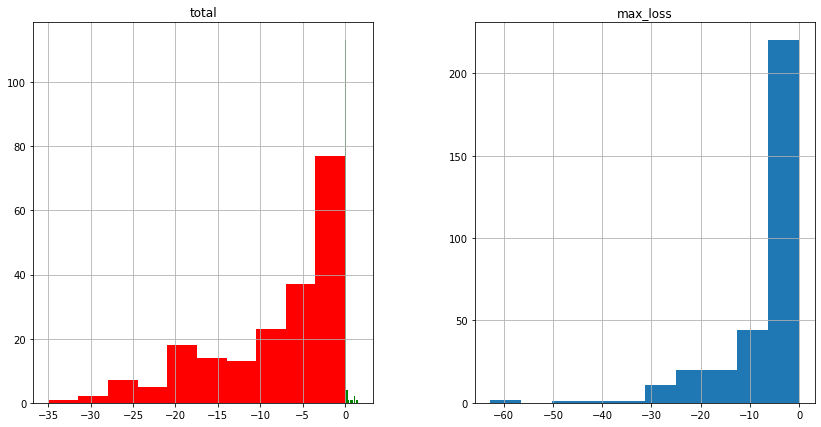

In [46]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(7)
fig.set_figwidth(14)
grid_results[grid_results['total'] < 0].hist('total', ax=axs[0], color='r')
grid_results[grid_results['total'] >= 0].hist('total', ax=axs[0], color='g')
grid_results.hist('max_loss', ax=axs[1])

plt.show()

grid_results* Most strategies lose money, let's see why some of them dont

In [66]:
grid_results.groupby(['sigma', 'gamma', 'kappa']).mean().reset_index()

,sigma,gamma,kappa,delay,total,max_loss,volatility,std
0,0.1,0.01,0.1,412500000.0,-0.641620,-4.106338,6.822352,1.087055
1,0.1,0.01,1.0,412500000.0,-17.674006,-30.367355,10.921195,8.469163
2,0.1,0.01,1.5,412500000.0,-20.237599,-35.262307,11.328023,9.858734
3,0.1,0.01,3.0,412500000.0,-21.221033,-40.531492,12.765255,11.793557
4,0.1,0.10,0.1,412500000.0,-3.456325,-7.924095,7.758708,2.072653
...,...,...,...,...,...,...,...,...
75,50.0,4.00,3.0,412500000.0,0.000000,0.000000,0.000000,0.000000
76,50.0,10.00,0.1,412500000.0,0.000000,0.000000,0.000000,0.000000
77,50.0,10.00,1.0,412500000.0,0.000000,0.000000,0.000000,0.000000
78,50.0,10.00,1.5,412500000.0,0.000000,0.000000,0.000000,0.000000


## Analysing results

In [63]:
import plotly.express as px

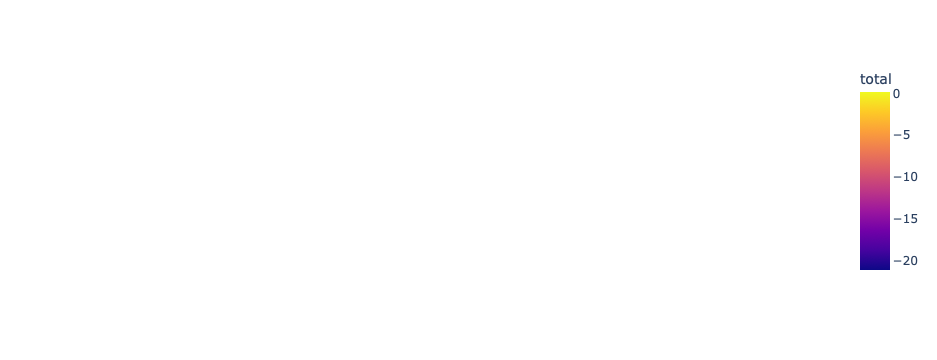

In [67]:
fig = px.scatter_3d(grid_results.groupby(['sigma', 'gamma', 'kappa']).mean().reset_index(), x='gamma', y='sigma', z='kappa',
                    color='total')
fig.show()

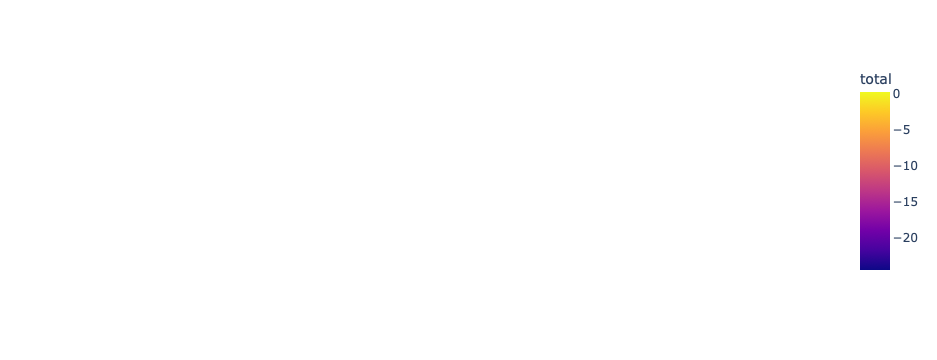

In [68]:
fig = px.scatter_3d(grid_results.groupby(['delay', 'gamma', 'sigma']).mean().reset_index(), x='delay', y='sigma', z='gamma',
                    color='total')
fig.show()

### 10 best strategies

In [54]:
grid_results.iloc[-10:]

,delay,sigma,gamma,kappa,total,max_loss,volatility,std
310,50000000,10.0,1.00,3.0,0.157629,-0.108860,0.868491,0.080966
311,50000000,10.0,1.00,1.5,0.162092,-0.106852,0.870266,0.083054
312,100000000,10.0,0.10,0.1,0.179959,-0.107724,0.659060,0.114478
313,1000000000,50.0,0.01,0.1,0.192436,-0.045115,0.649955,0.091842
314,50000000,10.0,0.10,0.1,0.338478,-0.155910,0.877530,0.182659
315,500000000,1.0,0.01,0.1,0.665258,-2.142965,5.564223,0.772184
316,500000000,0.1,0.01,0.1,0.799125,-2.303506,5.780467,0.776285
317,50000000,10.0,0.01,0.1,1.067199,-0.035840,1.523897,0.385538
318,50000000,0.1,0.10,0.1,1.136885,-3.583542,7.437822,1.037195
319,50000000,1.0,0.10,0.1,1.464184,-0.135593,5.188007,0.425309


### Best returns

In [48]:
grid_results.loc[grid_results['total'].argmax()]

delay         5.000000e+07
sigma         1.000000e+00
gamma         1.000000e-01
kappa         1.000000e-01
total         1.464184e+00
max_loss     -1.355928e-01
volatility    5.188007e+00
std           4.253095e-01
Name: 319, dtype: float64

#### Params: gamma = 0.1, sigma = 1, kappa = 0.1
#### Total = 1.46, max DD = -1.35, volatility = 5.18%

### Analyse Gamma - inventory control

In [49]:
grid_results.groupby(['gamma'])['total'].mean()

gamma
0.01    -7.433570
0.10    -5.226104
1.00    -4.343538
4.00    -4.050948
10.00   -3.691692
Name: total, dtype: float64

In [50]:
grid_results.groupby(['gamma'])['max_loss'].mean()

gamma
0.01    -10.958910
0.10     -6.825150
1.00     -4.616519
4.00     -4.073003
10.00    -3.695832
Name: max_loss, dtype: float64

* Looks like higher gamma results in better returns and better loss controll for bull market

### Analyse Sigma - Implied Vol

In [51]:
grid_results.groupby(['sigma'])['total'].mean()

sigma
0.1    -13.095299
1.0     -5.552136
10.0    -1.140127
50.0    -0.009119
Name: total, dtype: float64

In [52]:
grid_results.groupby(['sigma'])['max_loss'].mean()

sigma
0.1    -17.028401
1.0     -5.879043
10.0    -1.198631
50.0    -0.029456
Name: max_loss, dtype: float64

**70% Probably closer to market volatility**

Looks it's better to choose closest volatiltiy

### Analyse Kappa

In [427]:
grid_results.groupby(['kappa'])['results'].mean()

kappa
0.1   -425.909180
1.0   -746.102040
1.5   -680.401251
3.0   -422.871213
5.0   -414.937768
Name: results, dtype: float64

In [428]:
grid_results.groupby(['kappa'])['max drawdown'].mean()

kappa
0.1    -802.160438
1.0   -1380.123891
1.5   -1199.751410
3.0    -639.527971
5.0    -583.395606
Name: max drawdown, dtype: float64

* Higher kappa is better

Probably not the best way to gridsearch kappa as it is parameter of orders inflow

### Plotting results

In [111]:
def plot_results(gamma, sigma, kappa, strategy):
    latency = pd.Timedelta(10, 'ms').delta
    md_latency = pd.Timedelta(10, 'ms').delta

    delay = pd.Timedelta(0.1, 's').delta
    strat = strategy(delay = delay, theta = sigma**2, gamma = gamma, k = kappa, max_pos=100)
    
    res = strat.run(Sim(md, latency, md_latency))
    df = get_pnl(res['update'])
    df['reserve_price'] = df['mid_price'] - gamma * sigma * sigma * (df['BTC']/0.001)
    df['spread'] = (gamma * sigma**2 + 2/gamma * np.log(1 + gamma/kappa))

    plt.figure(figsize=(22, 25))
    dt = pd.to_datetime(df.receive_ts)

    plt.subplot(6, 1, 1)
    plt.plot(dt, df.reserve_price, '-', label='reservation price')
    plt.plot(dt, df.mid_price, '-', label='mid price')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("BTC price", fontsize=13)
    plt.title("BTC price", fontsize=15)
    plt.legend()
    plt.grid()

    plt.subplot(6, 1, 2)
    plt.plot(dt, df.reserve_price - df['spread']/2, '-', c='g', label='ASK pos')
    plt.plot(dt, df.reserve_price + df['spread']/2, '-', c='r', label='BID pos')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("spread", fontsize=13)
    plt.title("spread", fontsize=15)
    plt.grid()

    plt.subplot(6, 1, 3)
    plt.plot(dt, df.reserve_price - df.mid_price, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("reserve_price-mid_price", fontsize=13)
    plt.title("reserve price - mid price", fontsize=15)
    plt.grid()
    

    ax1 = plt.subplot(6, 1, 4)
    ax2 = ax1.twinx()
    ax1.plot(dt, df.BTC, '-', label='BTC reserves')
    ax2.plot(dt, df.USD, '-', color='g', label='USD reserves')
    ax1.set_xlabel("time", fontsize=13)
    ax1.set_ylabel("BTC position", fontsize=13)
    ax2.set_ylabel("USD position", fontsize=13)
    ax1.legend()
    ax2.legend()
    plt.title("Inventory for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.subplot(6, 1, 6)
    plt.plot(dt, df.total, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("PnL", fontsize=13)
    plt.title("PnL for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()
    
    plt.subplot(6, 1, 5)
    plt.plot(dt, df.traded_volume, '-')
    plt.xlabel("time", fontsize=13)
    plt.ylabel("Volume", fontsize=13)
    plt.title("Cum Traded Volume for gamma = %.1f, sigma = %.1f, k = %.1f"%(gamma, sigma, kappa), fontsize=15)
    plt.grid()

    plt.tight_layout()
    plt.show()

In [121]:
T = pd.Timedelta(1, 'h').delta
md = load_md_from_file(path=PATH_TO_FILE, T=T)

In [124]:
# Selecting best params
gamma = 0.1
sigma = 0.8
kappa = 1

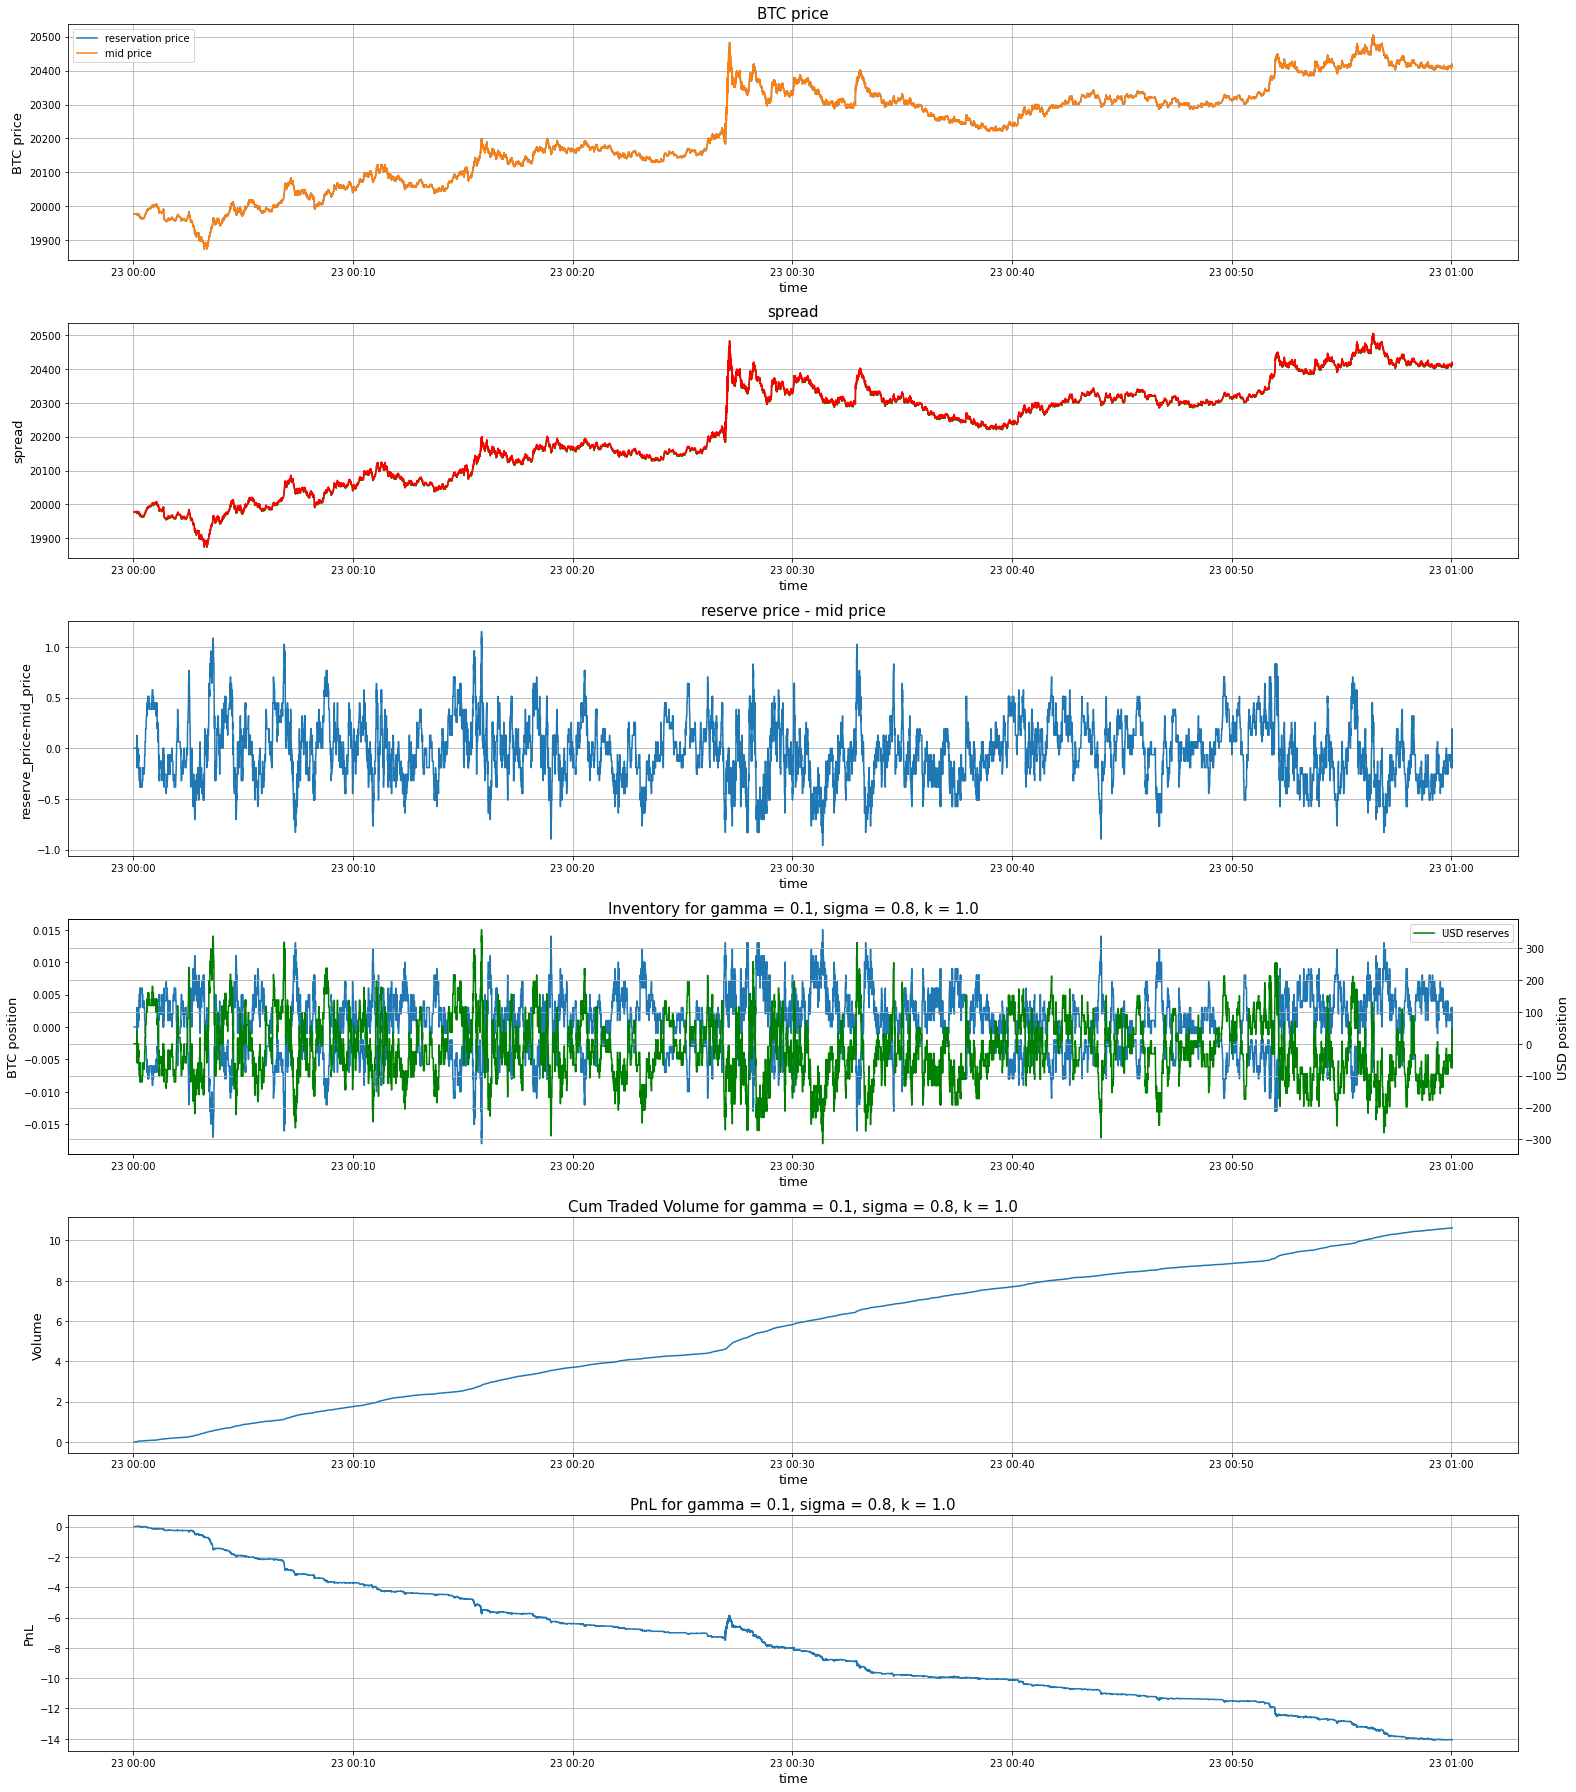

In [125]:
plot_results(gamma = gamma, sigma = sigma, kappa = kappa, strategy = StoikovStrategyOriginal)

In [126]:
# Selecting best params
gamma = 0.1
sigma = 0.1
kappa = 1

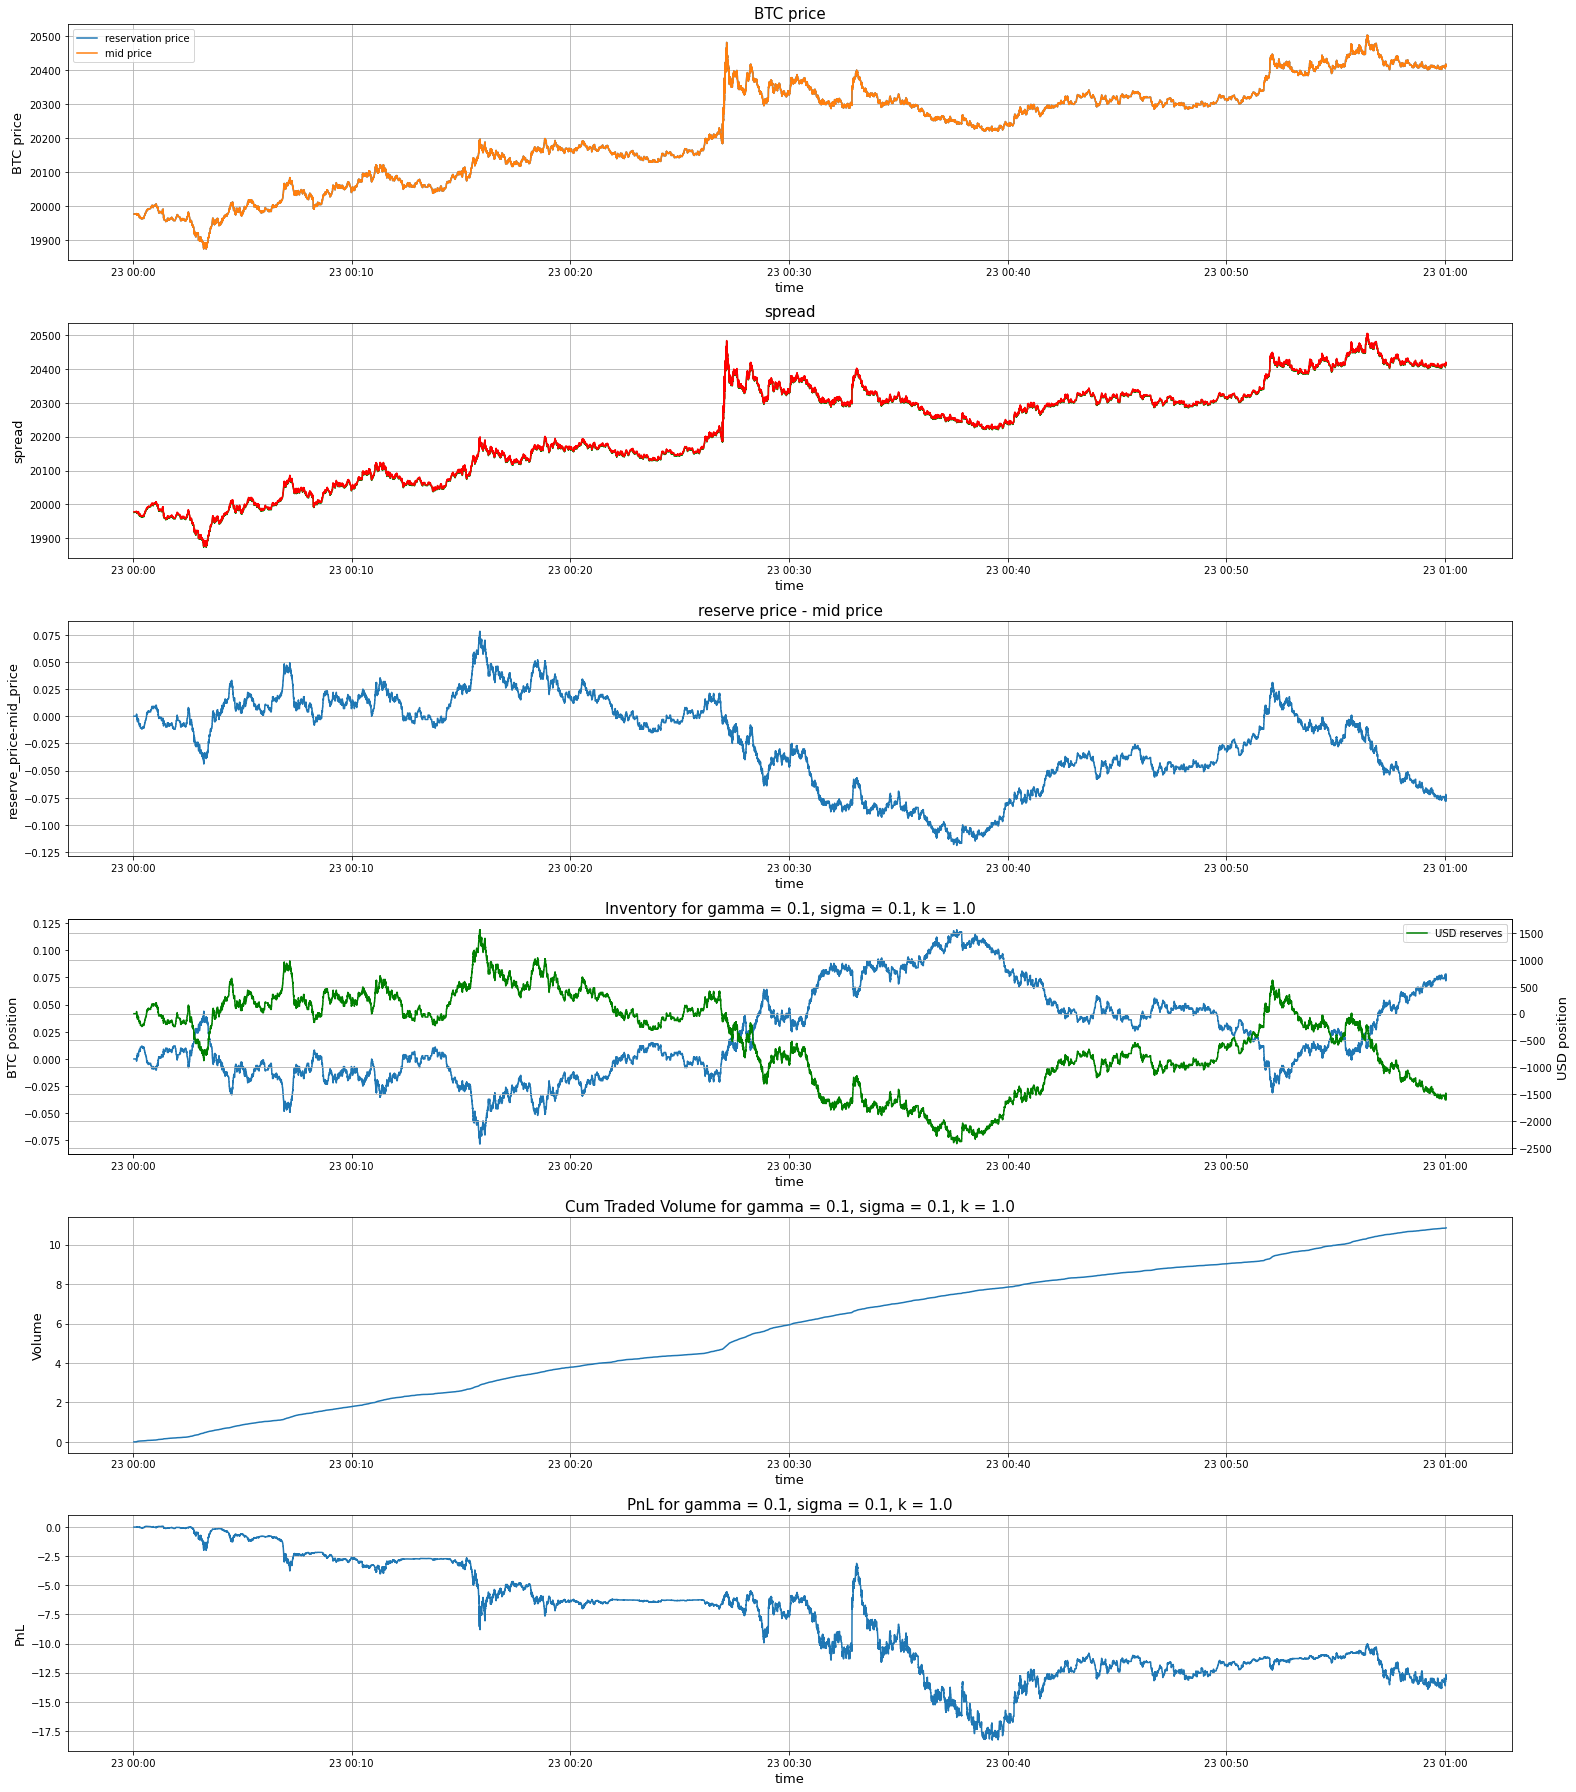

In [127]:
plot_results(gamma = gamma, sigma = sigma, kappa = kappa, strategy = StoikovStrategyOriginal)

* **We collect good volume**

### Let's look at the worst result

In [129]:
grid_results.loc[grid_results['total'].argmin()]

delay         1.000000e+08
sigma         1.000000e-01
gamma         1.000000e-02
kappa         3.000000e+00
total        -3.493657e+01
max_loss     -6.274647e+01
volatility    1.652343e+01
std           1.839784e+01
Name: 0, dtype: float64

In [130]:
gamma = 0.01
sigma = 0.1
kappa = 3

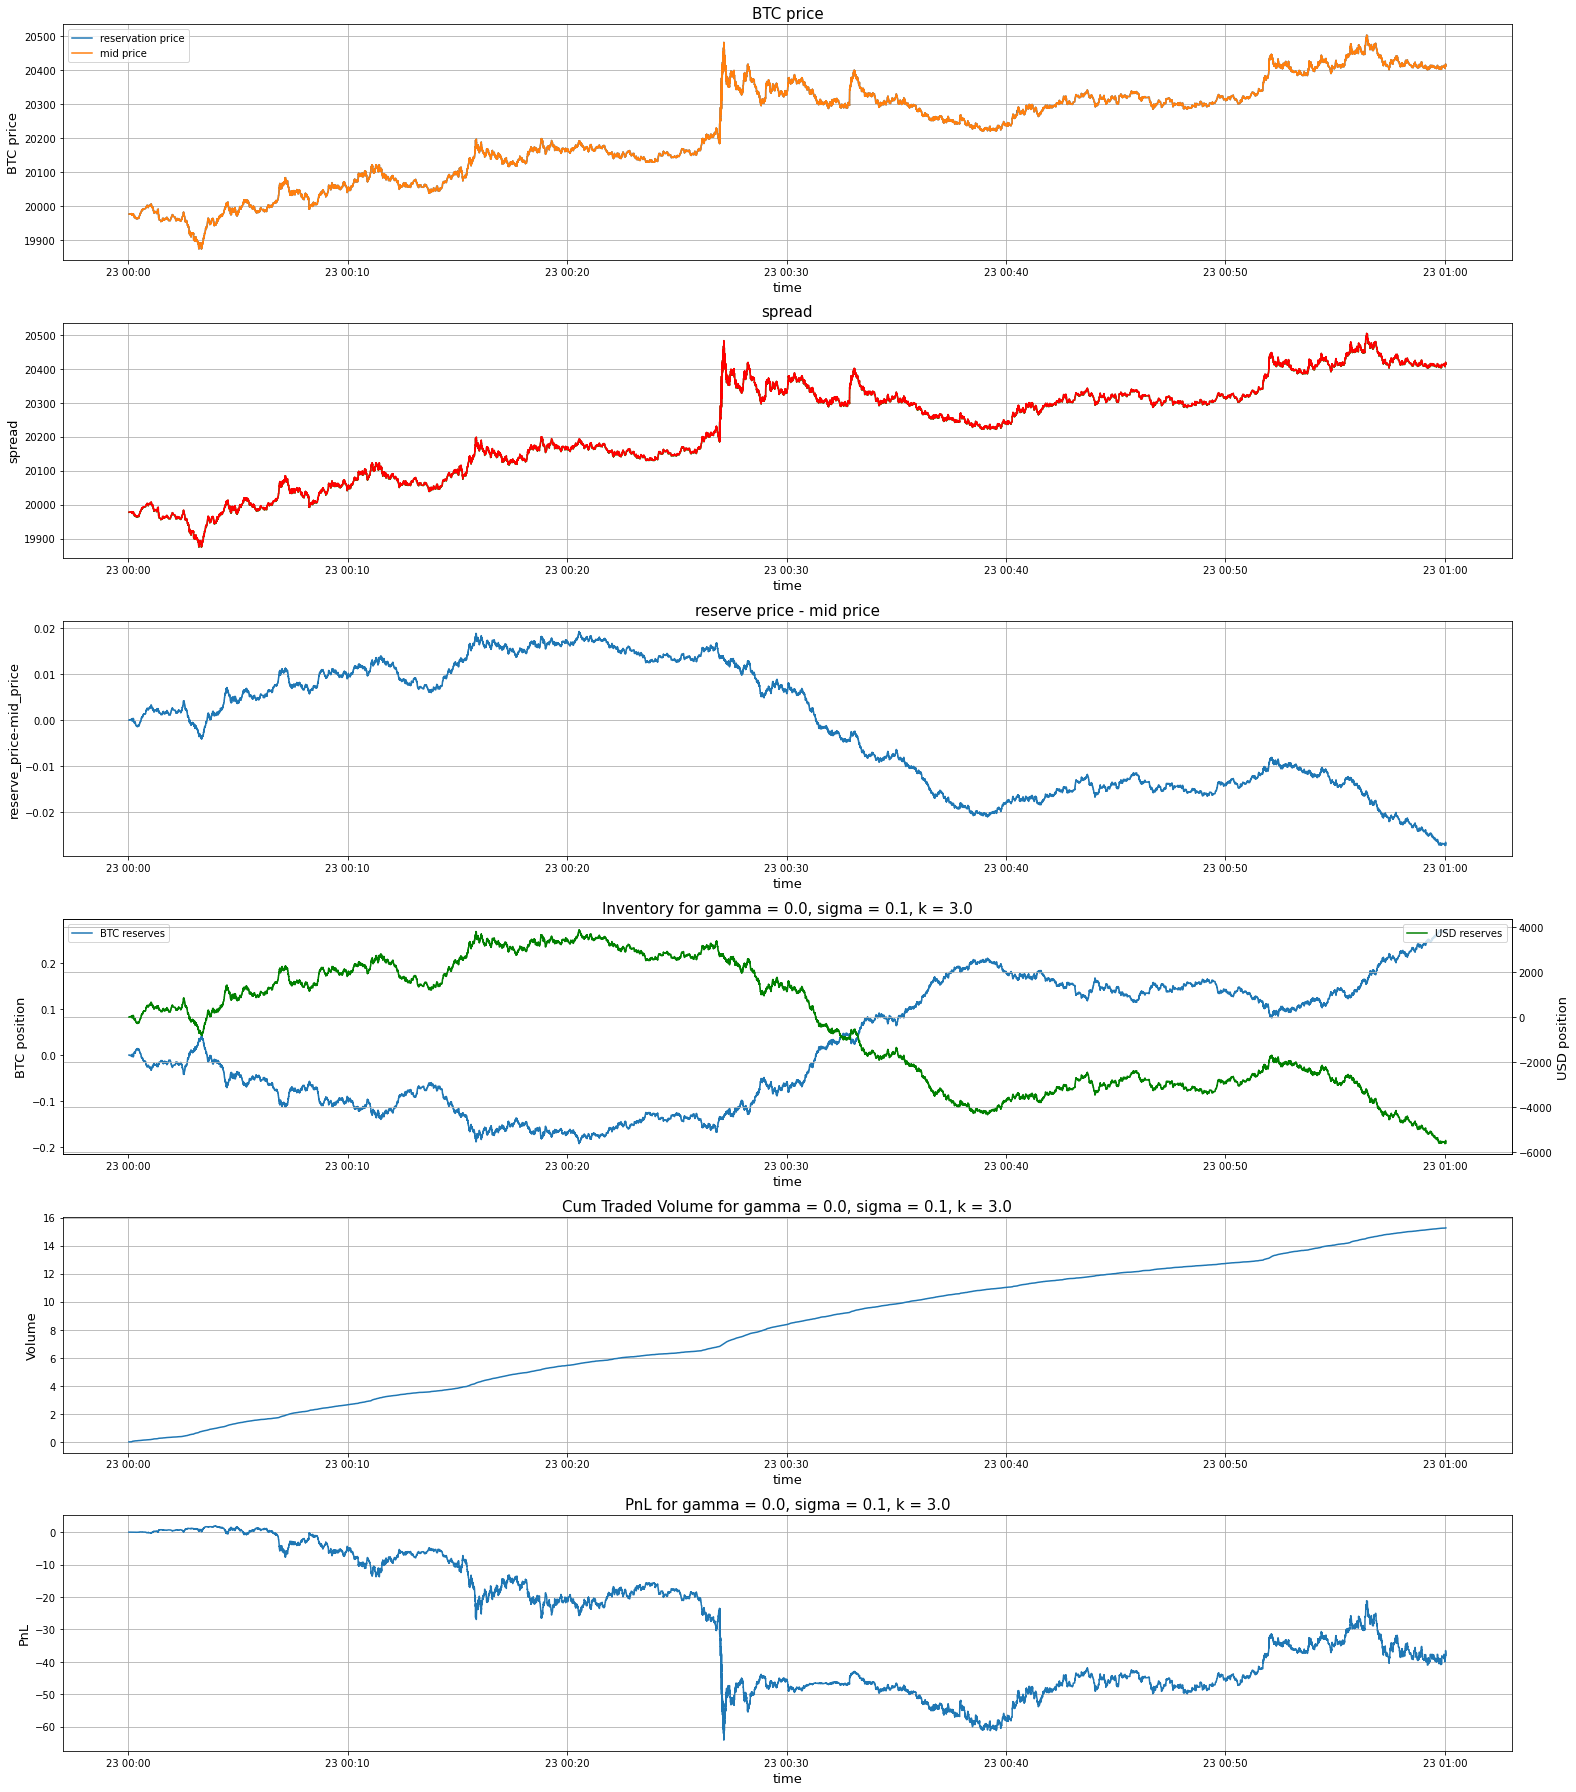

In [131]:
plot_results(gamma = gamma, sigma = sigma, kappa = kappa, strategy = StoikovStrategyOriginal)